# Implementing a Low Rank Adapter (LoRA) (8 points)

Objective of this exercice:

Given a neural network (NN) classifier pre-trained on the subset of MNIST containing digits 0...4,
you will fine-tune this NN, by optimizing all weights, and compare the test accuracy of this baseline model versus fine-tuning a LoRA.

The neural network that we will define is artificially big because LoRA is usually applied to Large Language Models of billions of parameters

**What is a LoRA ?**

LoRA (Low-Rank Adaptation of Large Language Models) is a popular and lightweight training technique that significantly reduces the number of trainable parameters. It works by inserting a smaller number of new weights into the model and only these are trained. This makes training with LoRA much faster, memory-efficient, and produces smaller model weights (a few hundred MBs), which are easier to store and share.

<div style="display: flex; justify-content: space-between;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_fig.png' style="width: 30%;">
    <img src='https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/imgs/lora_text.png' style="width: 70%;">
</div>



References:

https://arxiv.org/pdf/2106.09685.pdf

https://lightning.ai/pages/community/tutorial/lora-llm/

https://huggingface.co/docs/diffusers/main/en/training/lora


In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, Subset
import torch.nn.utils.parametrize as parametrize
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Make torch deterministic
_ = torch.manual_seed(0)


# Decide which device we want to run on
ngpu=1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
#Normalizing MNIST
#These values are the mean and std deviation of the MNIST dataset.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# load MNIST
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# keep images of desired labels
class_names = [0, 1, 2, 3, 4]

# create a mask to filter indices for each label
train_mask = torch.tensor([label in class_names for label in mnist_train.targets])
test_mask = torch.tensor([label in class_names for label in mnist_test.targets])

# Create Subset datasets for train, validation, and test
train_dataset = Subset(mnist_train, torch.where(train_mask)[0])
test_dataset = Subset(mnist_test, torch.where(test_mask)[0])

# split train into train & validation
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size=128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 263197381.96it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32311468.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 52075142.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19885729.40it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
len(train_dataset),len(val_dataset),len(test_dataset)

(21417, 9179, 5139)

# Architecture of the classifier

In [4]:
#note that last layer has 5 neurons for digits 0...4
#and the same layer will be used for 5...9

class classifier(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=2000):
        super(classifier,self).__init__()

        self.linear1 = nn.Linear(28*28, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 5)
        self.relu = nn.ReLU()


        self.dropout = nn.Dropout(0.5)



    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.dropout(x)
        x = self.relu(self.linear2(x))
        x = self.dropout(x)
        x = self.linear3(x)
        return x

net = classifier().to(device)

# Code for training loop & validation

In [5]:
#We set a lower learning rate when we will fine-tune on the subset of MNIST containing digits 5...9
#so that fine-tuning don't change pre-training weights too much.

#Since the NN is big, we add weight decay to regularize it otherwise it will overfit too much too fast
def adjust_optimizer(name, parameters):
    lr = 0.001
    if name == "subset2":
        lr = 0.00001
    return torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)

# to do label prediction during training we use argmax on the last layer, which output a vector of 5 components
# so y_hat will be between 0 and 4, we thus have to "translate" y_true so that it's in the right range

# the name variable will be used later on to recognize on which dataset we are
# and do the corresponding label translation, and set the good hyperparameters
def process_labels(name, labels):
    if 'subset2' in name:
        labels = labels - 5
    return labels


def run_epoch(loader, name, net, optimizer, cross_el, total_iterations_limit=None):
    net.train() if optimizer else net.eval()

    loss_sum = 0
    num_iterations = 0

    data_iterator = tqdm(loader, desc=f'Training' if optimizer else f'Validation')
    if total_iterations_limit is not None:
        data_iterator.total = total_iterations_limit

    for data in data_iterator:
        num_iterations += 1
        x, y = data
        x, y = x.to(device), y.to(device)
        x = x.view(-1, 28*28)
        optimizer.zero_grad() if optimizer else None
        output = net(x)
        loss = cross_el(output, process_labels(name, y))
        loss_sum += loss.item()
        avg_loss = loss_sum / num_iterations
        data_iterator.set_postfix(loss=avg_loss)
        if optimizer:
            loss.backward()
            optimizer.step()

    return loss_sum / len(data_iterator)

def train(train_loader, val_loader, name, net, epochs=5, total_iterations_limit=None):
    cross_el = nn.CrossEntropyLoss()
    optimizer = adjust_optimizer(name, net.parameters())

    total_iterations = 0
    train_loss_lst, val_loss_lst = [], []

    for epoch in range(epochs):
        train_loss = run_epoch(train_loader, name, net, optimizer, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss}")
        train_loss_lst.append(train_loss)

        val_loss = run_epoch(val_loader, name, net, None, cross_el, total_iterations_limit)
        print(f"Epoch [{epoch+1}/{epochs}] Validation Loss: {val_loss}")
        val_loss_lst.append(val_loss)

    return train_loss_lst, val_loss_lst

In [6]:
def plot_losses(train_loss_lst, val_loss_lst):
    plt.plot(train_loss_lst,label="train")
    plt.plot(val_loss_lst,label="val")
    plt.legend()

# If you have GPU access, or simply want to train your own model, run this code

> 縮排段落



In [7]:
train_loss_lst, val_loss_lst = train(train_loader, val_loader, "subset1", net, epochs=30)

Training: 100%|██████████| 168/168 [00:05<00:00, 28.03it/s, loss=0.15]


Epoch [1/30] Train Loss: 0.14974932339308517


Validation: 100%|██████████| 72/72 [00:02<00:00, 28.17it/s, loss=0.0825]


Epoch [1/30] Validation Loss: 0.08251338893185473


Training: 100%|██████████| 168/168 [00:08<00:00, 20.18it/s, loss=0.0727]


Epoch [2/30] Train Loss: 0.0727058290171304


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.59it/s, loss=0.0739]


Epoch [2/30] Validation Loss: 0.07392260182597157


Training: 100%|██████████| 168/168 [00:05<00:00, 28.06it/s, loss=0.0526]


Epoch [3/30] Train Loss: 0.05263905182004064


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.08it/s, loss=0.045]


Epoch [3/30] Validation Loss: 0.044970981440403394


Training: 100%|██████████| 168/168 [00:05<00:00, 30.75it/s, loss=0.051]


Epoch [4/30] Train Loss: 0.051019202169430046


Validation: 100%|██████████| 72/72 [00:02<00:00, 28.77it/s, loss=0.0399]


Epoch [4/30] Validation Loss: 0.039921130816057686


Training: 100%|██████████| 168/168 [00:04<00:00, 33.61it/s, loss=0.0439]


Epoch [5/30] Train Loss: 0.04388246592550006


Validation: 100%|██████████| 72/72 [00:02<00:00, 35.54it/s, loss=0.057]


Epoch [5/30] Validation Loss: 0.05699470036132778


Training: 100%|██████████| 168/168 [00:06<00:00, 24.36it/s, loss=0.0388]


Epoch [6/30] Train Loss: 0.0388344281292077


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.99it/s, loss=0.0555]


Epoch [6/30] Validation Loss: 0.0555133964581829


Training: 100%|██████████| 168/168 [00:06<00:00, 26.68it/s, loss=0.0382]


Epoch [7/30] Train Loss: 0.03818635740650019


Validation: 100%|██████████| 72/72 [00:02<00:00, 29.63it/s, loss=0.0471]


Epoch [7/30] Validation Loss: 0.04714426022757026


Training: 100%|██████████| 168/168 [00:05<00:00, 33.32it/s, loss=0.0322]


Epoch [8/30] Train Loss: 0.032195798712477665


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.29it/s, loss=0.0435]


Epoch [8/30] Validation Loss: 0.04350943462062181


Training: 100%|██████████| 168/168 [00:05<00:00, 29.25it/s, loss=0.0325]


Epoch [9/30] Train Loss: 0.032548023160156196


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.69it/s, loss=0.0363]


Epoch [9/30] Validation Loss: 0.03634637334946294


Training: 100%|██████████| 168/168 [00:05<00:00, 31.97it/s, loss=0.0323]


Epoch [10/30] Train Loss: 0.032335361063208744


Validation: 100%|██████████| 72/72 [00:02<00:00, 26.36it/s, loss=0.0439]


Epoch [10/30] Validation Loss: 0.04394077951696494


Training: 100%|██████████| 168/168 [00:05<00:00, 32.86it/s, loss=0.0353]


Epoch [11/30] Train Loss: 0.03525609094746566


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.37it/s, loss=0.0402]


Epoch [11/30] Validation Loss: 0.04019067670136186


Training: 100%|██████████| 168/168 [00:05<00:00, 29.31it/s, loss=0.0289]


Epoch [12/30] Train Loss: 0.02887745749432638


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.03it/s, loss=0.048]


Epoch [12/30] Validation Loss: 0.047962664700106766


Training: 100%|██████████| 168/168 [00:05<00:00, 32.73it/s, loss=0.0332]


Epoch [13/30] Train Loss: 0.033212027780661756


Validation: 100%|██████████| 72/72 [00:02<00:00, 31.54it/s, loss=0.0495]


Epoch [13/30] Validation Loss: 0.04945662647716947


Training: 100%|██████████| 168/168 [00:05<00:00, 28.39it/s, loss=0.0241]


Epoch [14/30] Train Loss: 0.024146842429088013


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.56it/s, loss=0.0454]


Epoch [14/30] Validation Loss: 0.045374524898256316


Training: 100%|██████████| 168/168 [00:05<00:00, 30.63it/s, loss=0.0311]


Epoch [15/30] Train Loss: 0.031124311276514726


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.72it/s, loss=0.0622]


Epoch [15/30] Validation Loss: 0.062247429725781935


Training: 100%|██████████| 168/168 [00:05<00:00, 32.79it/s, loss=0.0277]


Epoch [16/30] Train Loss: 0.027696087993977665


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.11it/s, loss=0.0529]


Epoch [16/30] Validation Loss: 0.0529151780938264


Training: 100%|██████████| 168/168 [00:05<00:00, 28.98it/s, loss=0.0261]


Epoch [17/30] Train Loss: 0.026115033389335924


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.91it/s, loss=0.042]


Epoch [17/30] Validation Loss: 0.04201710590723451


Training: 100%|██████████| 168/168 [00:05<00:00, 32.72it/s, loss=0.0265]


Epoch [18/30] Train Loss: 0.026536672590910235


Validation: 100%|██████████| 72/72 [00:02<00:00, 25.62it/s, loss=0.0423]


Epoch [18/30] Validation Loss: 0.042308687057862296


Training: 100%|██████████| 168/168 [00:05<00:00, 32.54it/s, loss=0.0236]


Epoch [19/30] Train Loss: 0.023623232239472037


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.02it/s, loss=0.0461]


Epoch [19/30] Validation Loss: 0.046063210224600776


Training: 100%|██████████| 168/168 [00:05<00:00, 28.43it/s, loss=0.0189]


Epoch [20/30] Train Loss: 0.018922397777628032


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.36it/s, loss=0.0467]


Epoch [20/30] Validation Loss: 0.046737306796962405


Training: 100%|██████████| 168/168 [00:05<00:00, 30.52it/s, loss=0.022]


Epoch [21/30] Train Loss: 0.02201877897451119


Validation: 100%|██████████| 72/72 [00:03<00:00, 21.64it/s, loss=0.0506]


Epoch [21/30] Validation Loss: 0.050577840019589836


Training: 100%|██████████| 168/168 [00:05<00:00, 33.19it/s, loss=0.0274]


Epoch [22/30] Train Loss: 0.027364984396453587


Validation: 100%|██████████| 72/72 [00:02<00:00, 34.22it/s, loss=0.045]


Epoch [22/30] Validation Loss: 0.04503257767871421


Training: 100%|██████████| 168/168 [00:07<00:00, 22.99it/s, loss=0.027]


Epoch [23/30] Train Loss: 0.026974615275575854


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.31it/s, loss=0.046]


Epoch [23/30] Validation Loss: 0.04601384805662039


Training: 100%|██████████| 168/168 [00:05<00:00, 32.57it/s, loss=0.0247]


Epoch [24/30] Train Loss: 0.024679075321121974


Validation: 100%|██████████| 72/72 [00:02<00:00, 25.83it/s, loss=0.052]


Epoch [24/30] Validation Loss: 0.051963286942938995


Training: 100%|██████████| 168/168 [00:06<00:00, 28.00it/s, loss=0.0227]


Epoch [25/30] Train Loss: 0.02269305546247952


Validation: 100%|██████████| 72/72 [00:02<00:00, 32.86it/s, loss=0.0425]


Epoch [25/30] Validation Loss: 0.04245810768144212


Training: 100%|██████████| 168/168 [00:05<00:00, 28.58it/s, loss=0.0244]


Epoch [26/30] Train Loss: 0.024409375068769026


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.36it/s, loss=0.0426]


Epoch [26/30] Validation Loss: 0.0425777312912285


Training: 100%|██████████| 168/168 [00:05<00:00, 32.23it/s, loss=0.026]


Epoch [27/30] Train Loss: 0.02596881687198523


Validation: 100%|██████████| 72/72 [00:02<00:00, 25.63it/s, loss=0.0372]


Epoch [27/30] Validation Loss: 0.03724991662567037


Training: 100%|██████████| 168/168 [00:05<00:00, 32.39it/s, loss=0.0276]


Epoch [28/30] Train Loss: 0.027648606950043314


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.30it/s, loss=0.0443]


Epoch [28/30] Validation Loss: 0.04432549775060579


Training: 100%|██████████| 168/168 [00:06<00:00, 27.30it/s, loss=0.0292]


Epoch [29/30] Train Loss: 0.029202995721615957


Validation: 100%|██████████| 72/72 [00:02<00:00, 33.39it/s, loss=0.0453]


Epoch [29/30] Validation Loss: 0.04532906108960964


Training: 100%|██████████| 168/168 [00:05<00:00, 32.30it/s, loss=0.017]


Epoch [30/30] Train Loss: 0.016994555830738785


Validation: 100%|██████████| 72/72 [00:02<00:00, 30.16it/s, loss=0.0497]

Epoch [30/30] Validation Loss: 0.049672105197689435


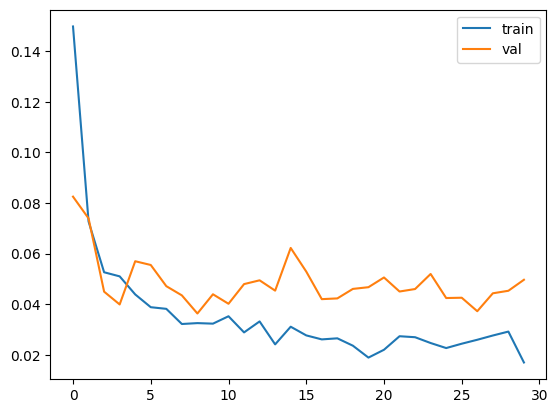

In [8]:
plot_losses(train_loss_lst,val_loss_lst)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# save the model
path1 = '/content/drive/My Drive/full_model.pth'
torch.save(net,path1)

path2 = '/content/drive/My Drive/state_dict_model.pth'
# Save the state dictionary
torch.save(net.state_dict(), path2)


# Otherwise load an already pre-trained model
Either the one you have created above, either the one already available at https://www.lri.fr/~gcharpia/deeppractice/2024/TP4/models/


In [15]:
net=torch.load(path1).to(device)

# Count the number of weights & compare it with parameters added by LoRA

In [16]:
original_weights = {}
for name, param in net.named_parameters():
    original_weights[name] = param.clone().detach()

In [17]:
# Print the size of the weights matrices of the network
# Save the count of the total number of parameters
net.eval()
total_parameters_original = 0
for index, layer in enumerate([net.linear1, net.linear2, net.linear3]):
    total_parameters_original += layer.weight.nelement() + layer.bias.nelement()
    print(f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape}')
print(f'Total number of parameters: {total_parameters_original:,}')

Layer 1: W: torch.Size([1000, 784]) + B: torch.Size([1000])
Layer 2: W: torch.Size([2000, 1000]) + B: torch.Size([2000])
Layer 3: W: torch.Size([5, 2000]) + B: torch.Size([5])
Total number of parameters: 2,797,005


# Test the model on digits 0...4

In [34]:
def test(loader, name, net, wrong_counts):
    correct = 0
    total = 0

    net.eval()
    with torch.no_grad():
        for data in tqdm(loader, desc=name):
            x, y = data
            x = x.to(device)
            y = y.to(device)
            y = process_labels(name, y)
            output = net(x.view(-1, 784))
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    correct += 1
                else:
                    wrong_digit = y[idx].item() + 5 if 'subset2' in name else y[idx].item()
                    wrong_counts[wrong_digit] += 1

                total += 1
    accuracy = round(correct / total, 3)
    print('')
    print(f'Accuracy: {accuracy}')
    for key, value in wrong_counts.items():
        print(f'Wrong counts for the digit {key}: {value}')

    return accuracy

test(test_loader, "Testing", net, {i: 0 for i in range(5)})


Testing: 100%|██████████| 41/41 [00:01<00:00, 27.53it/s]


Accuracy: 0.992
Wrong counts for the digit 0: 4
Wrong counts for the digit 1: 9
Wrong counts for the digit 2: 18
Wrong counts for the digit 3: 6
Wrong counts for the digit 4: 5


0.992

# Define train, validation, test sets for digits 5...9

__Question 1 (0.25 points) :__

In [19]:
#same code as before except for the mask

# create a mask to filter indices for each label, retrieve digits 5...9
#######
#TO-DO#
train_mask_subset2 = torch.tensor([label in range(5, 10) for label in mnist_train.targets])
test_mask_subset2 = torch.tensor([label in range(5, 10) for label in mnist_test.targets])
#######

# Create Subset datasets for train, validation, and test
train_dataset_subset2 = Subset(mnist_train, torch.where(train_mask_subset2)[0])
test_dataset_subset2 = Subset(mnist_test, torch.where(test_mask_subset2)[0])

# split train into train & validation
train_size_subset2 = int(0.7 * len(train_dataset_subset2))
val_size_subset2 = len(train_dataset_subset2) - train_size_subset2
train_dataset_subset2, val_dataset_subset2 = random_split(train_dataset_subset2, [train_size_subset2, val_size_subset2])

train_loader_subset2 = DataLoader(train_dataset_subset2, batch_size=batch_size, shuffle=True)
val_loader_subset2 = DataLoader(val_dataset_subset2, batch_size=batch_size, shuffle=False)
test_loader_subset2 = DataLoader(test_dataset_subset2, batch_size=batch_size, shuffle=False)

# Verify that pre-trained model on digits 0...4 is bad on digits 5...9

__Question 2 (0.25 points) :__

You should display the number of wrong predictions for each digits & global accuracy. \
Note that it's better than random guess ($\frac{1}{5}\times 100= $20%) for digit 8 and 9 because 3 looks like 8 and 4 looks like 9


In [35]:
#######
#TO-DO#
test_accuracy_subset2 = test(test_loader_subset2, "subset2", net, {i: 0 for i in range(5, 10)})
#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 31.07it/s]


Accuracy: 0.413
Wrong counts for the digit 5: 772
Wrong counts for the digit 6: 952
Wrong counts for the digit 7: 600
Wrong counts for the digit 8: 454
Wrong counts for the digit 9: 77


# Fine-tune the model on digits 5...9

__Question 3 (0.5 points) :__

You will fine-tune all the layers of the model (ie. all parameters of all fully-connected matrices) for 10 epochs

In [36]:
#######
#TO-DO#
train_loss_lst_subset2, val_loss_lst_subset2 = train(train_loader_subset2, val_loader_subset2, "subset2", net, epochs=10)
#######

Training: 100%|██████████| 161/161 [00:04<00:00, 32.99it/s, loss=6.44]


Epoch [1/10] Train Loss: 6.438088719148814


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.92it/s, loss=4.82]


Epoch [1/10] Validation Loss: 4.820169134416442


Training: 100%|██████████| 161/161 [00:06<00:00, 26.78it/s, loss=4.19]


Epoch [2/10] Train Loss: 4.18629246765042


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.06it/s, loss=2.76]


Epoch [2/10] Validation Loss: 2.76104101754617


Training: 100%|██████████| 161/161 [00:04<00:00, 32.62it/s, loss=2.47]


Epoch [3/10] Train Loss: 2.470310167496249


Validation: 100%|██████████| 69/69 [00:01<00:00, 34.67it/s, loss=1.55]


Epoch [3/10] Validation Loss: 1.5522149861722752


Training: 100%|██████████| 161/161 [00:05<00:00, 27.35it/s, loss=1.56]


Epoch [4/10] Train Loss: 1.5590154239850014


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.67it/s, loss=0.904]


Epoch [4/10] Validation Loss: 0.9042090626730435


Training: 100%|██████████| 161/161 [00:04<00:00, 33.36it/s, loss=1.01]


Epoch [5/10] Train Loss: 1.0074990221432276


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.90it/s, loss=0.595]


Epoch [5/10] Validation Loss: 0.5951090213181316


Training: 100%|██████████| 161/161 [00:05<00:00, 29.28it/s, loss=0.749]


Epoch [6/10] Train Loss: 0.7485987779146396


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.67it/s, loss=0.451]


Epoch [6/10] Validation Loss: 0.4507480393285337


Training: 100%|██████████| 161/161 [00:05<00:00, 30.91it/s, loss=0.587]


Epoch [7/10] Train Loss: 0.5870638219466121


Validation: 100%|██████████| 69/69 [00:03<00:00, 22.02it/s, loss=0.37]


Epoch [7/10] Validation Loss: 0.3697583671065344


Training: 100%|██████████| 161/161 [00:05<00:00, 30.59it/s, loss=0.502]


Epoch [8/10] Train Loss: 0.5015560945738917


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.07it/s, loss=0.316]


Epoch [8/10] Validation Loss: 0.31625292093857477


Training: 100%|██████████| 161/161 [00:05<00:00, 27.22it/s, loss=0.43]


Epoch [9/10] Train Loss: 0.4298329071043441


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.71it/s, loss=0.278]


Epoch [9/10] Validation Loss: 0.27842873702014703


Training: 100%|██████████| 161/161 [00:05<00:00, 31.71it/s, loss=0.387]


Epoch [10/10] Train Loss: 0.3870656595837255


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.47it/s, loss=0.249]

Epoch [10/10] Validation Loss: 0.24907030791476154


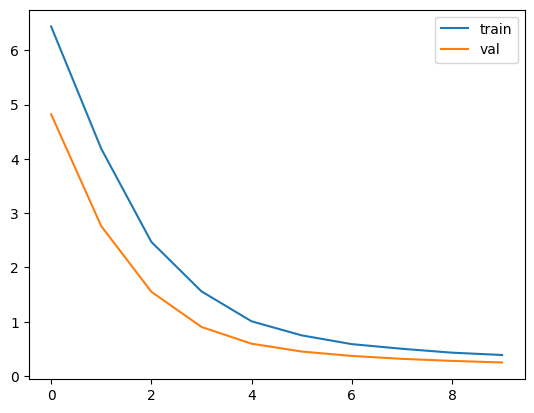

In [37]:
#plot the train and validation losses
#######
#TO-DO#
plot_losses(train_loss_lst_subset2, val_loss_lst_subset2)
#######

In [38]:
#test accuracy of fine-tuned model on digits 5...9
# & save this number into a variable, we will need it for final plot

#######
#TO-DO#
test_accuracy_finetuned_subset2 = test(test_loader_subset2, "subset2", net, {i: 0 for i in range(5, 10)})
#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 24.28it/s]


Accuracy: 0.929
Wrong counts for the digit 5: 82
Wrong counts for the digit 6: 32
Wrong counts for the digit 7: 69
Wrong counts for the digit 8: 96
Wrong counts for the digit 9: 65


# Fine-tune the model on digits 5...9 with LoRA

__Question 4 (2.5 points) :__

You will now implement one LoRA per layer

In [41]:
class ModifiedClassifier(nn.Module):
    def __init__(self, lora_rank):
        super(ModifiedClassifier, self).__init__()

        # Load the pretrained model
        self.pretrained_net = classifier().to(device)
        self.pretrained_net.load_state_dict(torch.load(path2))

        self.relu = nn.ReLU()

        self.dropout = nn.Dropout(0.5)

        # Define lora hyperparameters
        #######
        #TO-DO#
        self.lora_rank = lora_rank
        self.alpha = 2
        self.lora_dropout = 0.0
        #######

        # Define lora weights matrices for each layer in pretrained model
        #######
        #TO-DO#
        self.l1_lora_A = nn.Parameter(torch.Tensor(self.lora_rank, 784))
        self.l1_lora_B = nn.Parameter(torch.Tensor(1000, self.lora_rank))
        self.l2_lora_A = nn.Parameter(torch.Tensor(self.lora_rank, 1000))
        self.l2_lora_B = nn.Parameter(torch.Tensor(2000, self.lora_rank))
        self.l3_lora_A = nn.Parameter(torch.Tensor(self.lora_rank, 2000))
        self.l3_lora_B = nn.Parameter(torch.Tensor(5, self.lora_rank))
        #######

        # Initialization for lora layers
        #######
        #TO-DO#
        nn.init.normal_(self.l1_lora_A, std=self.alpha / self.lora_rank)
        nn.init.zeros_(self.l1_lora_B)
        nn.init.normal_(self.l2_lora_A, std=self.alpha / self.lora_rank)
        nn.init.zeros_(self.l2_lora_B)
        nn.init.normal_(self.l3_lora_A, std=self.alpha / self.lora_rank)
        nn.init.zeros_(self.l3_lora_B)
        #######

        # freeze non lora weights
        #######
        #TO-DO#
        for param in self.pretrained_net.parameters():
            param.requires_grad = False
        #######

    def lora_linear(self, x, layer, lora_A, lora_B):
        #Implement formula (3) in arxiv.org/pdf/2106.09685.pdf
        W0x = layer(x)
        delta_W_x = lora_B @ lora_A @ x.T
        h = W0x + self.alpha * delta_W_x.T
        return h


    def forward(self, input):
        x = input.view(-1, 28*28)

        # layer 1 (input size, hidden size)
        x = self.lora_linear(x, self.pretrained_net.linear1, self.l1_lora_A, self.l1_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        #complete the remaining code (layer 2 and 3)
        #######
        #TO-DO#
        # layer 2 (hidden size 1, hidden size 2)
        x = self.lora_linear(x, self.pretrained_net.linear2, self.l2_lora_A, self.l2_lora_B)
        x = self.relu(x)
        x = self.dropout(x)

        # layer 3 (hidden size 2, output size)
        x = self.lora_linear(x, self.pretrained_net.linear3, self.l3_lora_A, self.l3_lora_B)
        #######

        return x

lora_rank=1
# Create an instance of the modified network
modified_net = ModifiedClassifier(lora_rank).to(device)

Make a function that counts the number of parameters introduced by lora ( use the function torch.numel() )

In [42]:
# Count the parameters introduced by lora layers
#######
#TO-DO#
def count_lora_params(modified_net):
    # Count the parameters introduced by LoRA layers
    lora_params = 0
    for name, param in modified_net.named_parameters():
        if 'lora' in name:
            lora_params += torch.numel(param)
    return lora_params

lora_parameters_count = count_lora_params(modified_net)
print(f"Total number of parameters introduced by LoRA: {lora_parameters_count}")
#######

Total number of parameters introduced by LoRA: 6789


# Fine-Tune using LoRA of rank 1

__Question 5 (0.5 points) :__

In [44]:
#Fine tune this new model with loras of rank 1, on MNIST 5...9
#######
#TO-DO#
train_loss_lst_lora, val_loss_lst_lora = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)
#######

Training: 100%|██████████| 161/161 [00:05<00:00, 31.67it/s, loss=0.608]


Epoch [1/10] Train Loss: 0.6083365928682481


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.59it/s, loss=0.415]


Epoch [1/10] Validation Loss: 0.41501650084619934


Training: 100%|██████████| 161/161 [00:06<00:00, 26.69it/s, loss=0.576]


Epoch [2/10] Train Loss: 0.5755653734903158


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.06it/s, loss=0.401]


Epoch [2/10] Validation Loss: 0.40129288685494574


Training: 100%|██████████| 161/161 [00:05<00:00, 31.82it/s, loss=0.575]


Epoch [3/10] Train Loss: 0.5751334413978624


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.68it/s, loss=0.394]


Epoch [3/10] Validation Loss: 0.3936035905195319


Training: 100%|██████████| 161/161 [00:05<00:00, 27.33it/s, loss=0.573]


Epoch [4/10] Train Loss: 0.5731419561812596


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.29it/s, loss=0.388]


Epoch [4/10] Validation Loss: 0.3878803719644961


Training: 100%|██████████| 161/161 [00:05<00:00, 29.92it/s, loss=0.566]


Epoch [5/10] Train Loss: 0.5655197732567047


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.51it/s, loss=0.384]


Epoch [5/10] Validation Loss: 0.3842359586902287


Training: 100%|██████████| 161/161 [00:05<00:00, 30.18it/s, loss=0.568]


Epoch [6/10] Train Loss: 0.5680075324840427


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.17it/s, loss=0.381]


Epoch [6/10] Validation Loss: 0.3811831662188406


Training: 100%|██████████| 161/161 [00:06<00:00, 26.30it/s, loss=0.551]


Epoch [7/10] Train Loss: 0.55132498133997


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.89it/s, loss=0.377]


Epoch [7/10] Validation Loss: 0.3774698447922002


Training: 100%|██████████| 161/161 [00:05<00:00, 32.09it/s, loss=0.554]


Epoch [8/10] Train Loss: 0.5543730395921269


Validation: 100%|██████████| 69/69 [00:02<00:00, 34.15it/s, loss=0.376]


Epoch [8/10] Validation Loss: 0.3758537199186242


Training: 100%|██████████| 161/161 [00:06<00:00, 26.52it/s, loss=0.547]


Epoch [9/10] Train Loss: 0.5474247580729656


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.45it/s, loss=0.374]


Epoch [9/10] Validation Loss: 0.37385540487973584


Training: 100%|██████████| 161/161 [00:05<00:00, 31.67it/s, loss=0.548]


Epoch [10/10] Train Loss: 0.5476496425104438


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.08it/s, loss=0.371]

Epoch [10/10] Validation Loss: 0.3709273139635722


In [48]:
# Check that the frozen parameters are still unchanged by the finetuning
# Remember the dictionary "original_weights"
#######
#TO-DO#
for name, param in modified_net.pretrained_net.named_parameters():
    assert torch.equal(original_weights[name], param), "Weights have changed for frozen parameter"
print("Frozen parameters are unchanged.")
#######

Frozen parameters are unchanged.


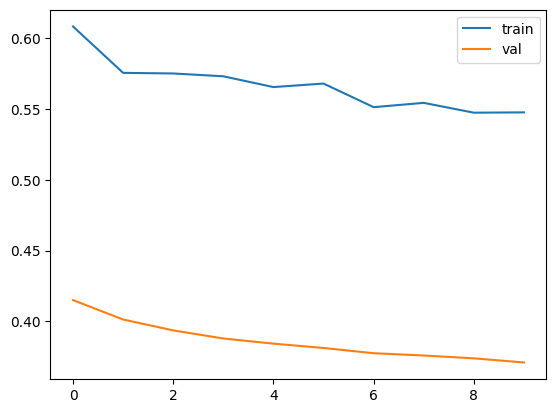

In [46]:
#plot losses
#######
#TO-DO#
plot_losses(train_loss_lst_lora, val_loss_lst_lora)
#######

In [47]:
#Compute test accuracy on MNIST 5...9 for that lora rank
#######
#TO-DO#
test_accuracy_finetuned_lora = test(test_loader_subset2, "subset2", modified_net, {i: 0 for i in range(5, 10)})
#######

subset2: 100%|██████████| 38/38 [00:01<00:00, 24.31it/s]


Accuracy: 0.894
Wrong counts for the digit 5: 117
Wrong counts for the digit 6: 31
Wrong counts for the digit 7: 136
Wrong counts for the digit 8: 154
Wrong counts for the digit 9: 76


# Try different LoRA rank

__Question 6 (4 points) :__

Fine-tune the pre-trained model using different lora ranks [1,2,4,8,16,32,64], evaluate it on the test set
and store the number of parameters added

Make a plot showing the test accuracy as a function of lora rank. \
Compare it to the test accuracy of the pre-trained model fine-tuned in the usual way on MNIST 5...9

Conclude by looking at the number of parameters added

Discuss what are the pros of LoRA, what possible applications do you envision for it ?

In [50]:
lora_ranks = [1, 2, 4, 8, 16, 32, 64]

test_accuracies_lora = []
parameters_added_lora = []

for rank in lora_ranks:
    modified_net = ModifiedClassifier(lora_rank=rank).to(device)
    _, _ = train(train_loader_subset2, val_loader_subset2, "subset2", modified_net, epochs=10)

    test_accuracy = test(test_loader_subset2, "subset2", modified_net, {i: 0 for i in range(5, 10)})
    test_accuracies_lora.append(test_accuracy)

    parameters_added = count_lora_params(modified_net)
    parameters_added_lora.append(parameters_added)

Training: 100%|██████████| 161/161 [00:05<00:00, 31.78it/s, loss=7.31]


Epoch [1/10] Train Loss: 7.312126837902188


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.34it/s, loss=6.34]


Epoch [1/10] Validation Loss: 6.342395969059156


Training: 100%|██████████| 161/161 [00:06<00:00, 24.74it/s, loss=6.33]


Epoch [2/10] Train Loss: 6.326484286266824


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.30it/s, loss=5.34]


Epoch [2/10] Validation Loss: 5.342451693355173


Training: 100%|██████████| 161/161 [00:05<00:00, 32.17it/s, loss=5.35]


Epoch [3/10] Train Loss: 5.34851676780985


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.96it/s, loss=4.39]


Epoch [3/10] Validation Loss: 4.385790220205335


Training: 100%|██████████| 161/161 [00:05<00:00, 30.61it/s, loss=4.74]


Epoch [4/10] Train Loss: 4.73678657875298


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.22it/s, loss=3.94]


Epoch [4/10] Validation Loss: 3.939455585203309


Training: 100%|██████████| 161/161 [00:06<00:00, 26.29it/s, loss=4.35]


Epoch [5/10] Train Loss: 4.345121718341519


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.09it/s, loss=3.58]


Epoch [5/10] Validation Loss: 3.5769331317017046


Training: 100%|██████████| 161/161 [00:05<00:00, 31.95it/s, loss=3.98]


Epoch [6/10] Train Loss: 3.983271659531208


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.80it/s, loss=3.24]


Epoch [6/10] Validation Loss: 3.2356971070386362


Training: 100%|██████████| 161/161 [00:06<00:00, 26.45it/s, loss=3.66]


Epoch [7/10] Train Loss: 3.6586752589444935


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.51it/s, loss=2.85]


Epoch [7/10] Validation Loss: 2.8491083003472593


Training: 100%|██████████| 161/161 [00:06<00:00, 26.63it/s, loss=3.24]


Epoch [8/10] Train Loss: 3.2421740049160785


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.06it/s, loss=2.44]


Epoch [8/10] Validation Loss: 2.4356608097104058


Training: 100%|██████████| 161/161 [00:05<00:00, 29.84it/s, loss=2.84]


Epoch [9/10] Train Loss: 2.835040473789902


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.68it/s, loss=2.1]


Epoch [9/10] Validation Loss: 2.1011232362277266


Training: 100%|██████████| 161/161 [00:05<00:00, 28.43it/s, loss=2.58]


Epoch [10/10] Train Loss: 2.5803285267042075


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.41it/s, loss=1.86]


Epoch [10/10] Validation Loss: 1.8632284126419951


subset2: 100%|██████████| 38/38 [00:01<00:00, 30.85it/s]



Accuracy: 0.632
Wrong counts for the digit 5: 522
Wrong counts for the digit 6: 341
Wrong counts for the digit 7: 176
Wrong counts for the digit 8: 635
Wrong counts for the digit 9: 113


Training: 100%|██████████| 161/161 [00:05<00:00, 32.17it/s, loss=7.58]


Epoch [1/10] Train Loss: 7.581766383248087


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.31it/s, loss=6.96]


Epoch [1/10] Validation Loss: 6.956747559533603


Training: 100%|██████████| 161/161 [00:06<00:00, 26.75it/s, loss=7.22]


Epoch [2/10] Train Loss: 7.217414855957031


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.43it/s, loss=6.57]


Epoch [2/10] Validation Loss: 6.571718243585116


Training: 100%|██████████| 161/161 [00:05<00:00, 31.67it/s, loss=6.81]


Epoch [3/10] Train Loss: 6.809471494662835


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.60it/s, loss=6.15]


Epoch [3/10] Validation Loss: 6.150742461715919


Training: 100%|██████████| 161/161 [00:05<00:00, 30.77it/s, loss=6.38]


Epoch [4/10] Train Loss: 6.383707505575618


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.96it/s, loss=5.64]


Epoch [4/10] Validation Loss: 5.640684259110603


Training: 100%|██████████| 161/161 [00:05<00:00, 27.93it/s, loss=5.86]


Epoch [5/10] Train Loss: 5.860246285148289


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.88it/s, loss=5.03]


Epoch [5/10] Validation Loss: 5.025598325591156


Training: 100%|██████████| 161/161 [00:05<00:00, 31.76it/s, loss=5.24]


Epoch [6/10] Train Loss: 5.236064330391262


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.39it/s, loss=4.36]


Epoch [6/10] Validation Loss: 4.358135689859805


Training: 100%|██████████| 161/161 [00:05<00:00, 27.01it/s, loss=4.64]


Epoch [7/10] Train Loss: 4.636420851168425


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.58it/s, loss=3.71]


Epoch [7/10] Validation Loss: 3.708144834076149


Training: 100%|██████████| 161/161 [00:05<00:00, 29.48it/s, loss=3.97]


Epoch [8/10] Train Loss: 3.969859718535998


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.25it/s, loss=3.06]


Epoch [8/10] Validation Loss: 3.059410333633423


Training: 100%|██████████| 161/161 [00:05<00:00, 29.54it/s, loss=3.47]


Epoch [9/10] Train Loss: 3.4714575939296934


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.27it/s, loss=2.48]


Epoch [9/10] Validation Loss: 2.475840475248254


Training: 100%|██████████| 161/161 [00:05<00:00, 29.10it/s, loss=2.9]


Epoch [10/10] Train Loss: 2.9020475734094657


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.06it/s, loss=2.06]


Epoch [10/10] Validation Loss: 2.0562610971754878


subset2: 100%|██████████| 38/38 [00:01<00:00, 30.72it/s]



Accuracy: 0.647
Wrong counts for the digit 5: 488
Wrong counts for the digit 6: 465
Wrong counts for the digit 7: 295
Wrong counts for the digit 8: 358
Wrong counts for the digit 9: 111


Training: 100%|██████████| 161/161 [00:05<00:00, 30.55it/s, loss=7.56]


Epoch [1/10] Train Loss: 7.5608696552537245


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.66it/s, loss=6.88]


Epoch [1/10] Validation Loss: 6.877990529157113


Training: 100%|██████████| 161/161 [00:06<00:00, 25.83it/s, loss=7.07]


Epoch [2/10] Train Loss: 7.068817114978103


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.13it/s, loss=6.37]


Epoch [2/10] Validation Loss: 6.367780063463294


Training: 100%|██████████| 161/161 [00:05<00:00, 31.96it/s, loss=6.51]


Epoch [3/10] Train Loss: 6.509646720767762


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.25it/s, loss=5.75]


Epoch [3/10] Validation Loss: 5.7469718732695645


Training: 100%|██████████| 161/161 [00:05<00:00, 29.04it/s, loss=5.84]


Epoch [4/10] Train Loss: 5.839013997072018


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.98it/s, loss=4.92]


Epoch [4/10] Validation Loss: 4.923983497896057


Training: 100%|██████████| 161/161 [00:05<00:00, 28.16it/s, loss=5]


Epoch [5/10] Train Loss: 4.999689232488596


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.55it/s, loss=4.05]


Epoch [5/10] Validation Loss: 4.053560060003529


Training: 100%|██████████| 161/161 [00:05<00:00, 29.65it/s, loss=4.28]


Epoch [6/10] Train Loss: 4.276546966955529


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.45it/s, loss=3.44]


Epoch [6/10] Validation Loss: 3.444342965665071


Training: 100%|██████████| 161/161 [00:06<00:00, 26.49it/s, loss=3.73]


Epoch [7/10] Train Loss: 3.733835388414608


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.98it/s, loss=2.96]


Epoch [7/10] Validation Loss: 2.961788084196008


Training: 100%|██████████| 161/161 [00:05<00:00, 32.03it/s, loss=3.31]


Epoch [8/10] Train Loss: 3.309894203399279


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.45it/s, loss=2.52]


Epoch [8/10] Validation Loss: 2.5162652817325317


Training: 100%|██████████| 161/161 [00:06<00:00, 26.76it/s, loss=2.87]


Epoch [9/10] Train Loss: 2.8661448029997927


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.79it/s, loss=2.12]


Epoch [9/10] Validation Loss: 2.1159783964571743


Training: 100%|██████████| 161/161 [00:05<00:00, 28.21it/s, loss=2.54]


Epoch [10/10] Train Loss: 2.538138076385356


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.86it/s, loss=1.76]


Epoch [10/10] Validation Loss: 1.7600626841835354


subset2: 100%|██████████| 38/38 [00:01<00:00, 31.17it/s]



Accuracy: 0.686
Wrong counts for the digit 5: 473
Wrong counts for the digit 6: 140
Wrong counts for the digit 7: 247
Wrong counts for the digit 8: 515
Wrong counts for the digit 9: 149


Training: 100%|██████████| 161/161 [00:05<00:00, 31.80it/s, loss=7.53]


Epoch [1/10] Train Loss: 7.528588158743722


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.73it/s, loss=6.73]


Epoch [1/10] Validation Loss: 6.726564545562302


Training: 100%|██████████| 161/161 [00:06<00:00, 26.67it/s, loss=6.81]


Epoch [2/10] Train Loss: 6.807962026655304


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.62it/s, loss=6.01]


Epoch [2/10] Validation Loss: 6.008840443431467


Training: 100%|██████████| 161/161 [00:05<00:00, 30.49it/s, loss=6.04]


Epoch [3/10] Train Loss: 6.0443949640167425


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.75it/s, loss=5.12]


Epoch [3/10] Validation Loss: 5.122466000957766


Training: 100%|██████████| 161/161 [00:05<00:00, 31.17it/s, loss=5.05]


Epoch [4/10] Train Loss: 5.045642972732923


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.26it/s, loss=4.08]


Epoch [4/10] Validation Loss: 4.077121586039446


Training: 100%|██████████| 161/161 [00:05<00:00, 27.54it/s, loss=4.06]


Epoch [5/10] Train Loss: 4.062173425781061


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.24it/s, loss=3.16]


Epoch [5/10] Validation Loss: 3.162712872892186


Training: 100%|██████████| 161/161 [00:05<00:00, 31.80it/s, loss=3.34]


Epoch [6/10] Train Loss: 3.339373727762921


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.30it/s, loss=2.51]


Epoch [6/10] Validation Loss: 2.506872045821038


Training: 100%|██████████| 161/161 [00:06<00:00, 26.32it/s, loss=2.71]


Epoch [7/10] Train Loss: 2.711944413481292


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.10it/s, loss=1.97]


Epoch [7/10] Validation Loss: 1.9707037884256113


Training: 100%|██████████| 161/161 [00:04<00:00, 32.36it/s, loss=2.2]


Epoch [8/10] Train Loss: 2.1968921756152042


Validation: 100%|██████████| 69/69 [00:02<00:00, 28.77it/s, loss=1.48]


Epoch [8/10] Validation Loss: 1.483551992022473


Training: 100%|██████████| 161/161 [00:05<00:00, 28.32it/s, loss=1.72]


Epoch [9/10] Train Loss: 1.7229324205321555


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.99it/s, loss=1.12]


Epoch [9/10] Validation Loss: 1.1166232072788735


Training: 100%|██████████| 161/161 [00:05<00:00, 30.09it/s, loss=1.37]


Epoch [10/10] Train Loss: 1.3731055911283316


Validation: 100%|██████████| 69/69 [00:02<00:00, 24.75it/s, loss=0.891]


Epoch [10/10] Validation Loss: 0.8906995356082916


subset2: 100%|██████████| 38/38 [00:01<00:00, 28.76it/s]



Accuracy: 0.795
Wrong counts for the digit 5: 259
Wrong counts for the digit 6: 153
Wrong counts for the digit 7: 174
Wrong counts for the digit 8: 274
Wrong counts for the digit 9: 138


Training: 100%|██████████| 161/161 [00:05<00:00, 31.09it/s, loss=7.56]


Epoch [1/10] Train Loss: 7.558154582977295


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.41it/s, loss=6.72]


Epoch [1/10] Validation Loss: 6.723410108815068


Training: 100%|██████████| 161/161 [00:06<00:00, 26.40it/s, loss=6.76]


Epoch [2/10] Train Loss: 6.762751988002232


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.65it/s, loss=5.87]


Epoch [2/10] Validation Loss: 5.868987159452576


Training: 100%|██████████| 161/161 [00:05<00:00, 30.65it/s, loss=5.77]


Epoch [3/10] Train Loss: 5.76558718622101


Validation: 100%|██████████| 69/69 [00:02<00:00, 27.57it/s, loss=4.78]


Epoch [3/10] Validation Loss: 4.777211486429408


Training: 100%|██████████| 161/161 [00:06<00:00, 26.08it/s, loss=4.56]


Epoch [4/10] Train Loss: 4.559984765437819


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.51it/s, loss=3.46]


Epoch [4/10] Validation Loss: 3.4614086220229883


Training: 100%|██████████| 161/161 [00:06<00:00, 26.14it/s, loss=3.33]


Epoch [5/10] Train Loss: 3.3310090992021264


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.34it/s, loss=2.37]


Epoch [5/10] Validation Loss: 2.3730362083600913


Training: 100%|██████████| 161/161 [00:05<00:00, 31.55it/s, loss=2.49]


Epoch [6/10] Train Loss: 2.4906602009483008


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.05it/s, loss=1.75]


Epoch [6/10] Validation Loss: 1.7482257321260977


Training: 100%|██████████| 161/161 [00:06<00:00, 26.49it/s, loss=1.89]


Epoch [7/10] Train Loss: 1.8885448512083256


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.78it/s, loss=1.26]


Epoch [7/10] Validation Loss: 1.2563604824784873


Training: 100%|██████████| 161/161 [00:05<00:00, 30.68it/s, loss=1.43]


Epoch [8/10] Train Loss: 1.4317213426465574


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.98it/s, loss=0.909]


Epoch [8/10] Validation Loss: 0.9094951714294545


Training: 100%|██████████| 161/161 [00:05<00:00, 29.35it/s, loss=1.11]


Epoch [9/10] Train Loss: 1.1102673378049956


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.57it/s, loss=0.731]


Epoch [9/10] Validation Loss: 0.730539007463317


Training: 100%|██████████| 161/161 [00:05<00:00, 28.87it/s, loss=0.94]


Epoch [10/10] Train Loss: 0.9399428367614746


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.10it/s, loss=0.629]


Epoch [10/10] Validation Loss: 0.6292313618072565


subset2: 100%|██████████| 38/38 [00:01<00:00, 31.04it/s]



Accuracy: 0.847
Wrong counts for the digit 5: 190
Wrong counts for the digit 6: 82
Wrong counts for the digit 7: 166
Wrong counts for the digit 8: 170
Wrong counts for the digit 9: 138


Training: 100%|██████████| 161/161 [00:05<00:00, 31.37it/s, loss=7.46]


Epoch [1/10] Train Loss: 7.462823547931932


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.55it/s, loss=6.5]


Epoch [1/10] Validation Loss: 6.504181011863377


Training: 100%|██████████| 161/161 [00:06<00:00, 25.80it/s, loss=6.34]


Epoch [2/10] Train Loss: 6.340801940941662


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.58it/s, loss=5.14]


Epoch [2/10] Validation Loss: 5.144556439441184


Training: 100%|██████████| 161/161 [00:05<00:00, 31.80it/s, loss=4.78]


Epoch [3/10] Train Loss: 4.779568946139412


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.32it/s, loss=3.51]


Epoch [3/10] Validation Loss: 3.5082449636597564


Training: 100%|██████████| 161/161 [00:05<00:00, 28.51it/s, loss=3.25]


Epoch [4/10] Train Loss: 3.252333943147837


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.29it/s, loss=2.18]


Epoch [4/10] Validation Loss: 2.1808951263842373


Training: 100%|██████████| 161/161 [00:05<00:00, 28.50it/s, loss=2.26]


Epoch [5/10] Train Loss: 2.2615667315003294


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.80it/s, loss=1.52]


Epoch [5/10] Validation Loss: 1.5158149591390637


Training: 100%|██████████| 161/161 [00:05<00:00, 30.43it/s, loss=1.65]


Epoch [6/10] Train Loss: 1.6454324759311558


Validation: 100%|██████████| 69/69 [00:02<00:00, 33.56it/s, loss=1.03]


Epoch [6/10] Validation Loss: 1.0309980658517368


Training: 100%|██████████| 161/161 [00:06<00:00, 26.40it/s, loss=1.18]


Epoch [7/10] Train Loss: 1.1830489405934115


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.26it/s, loss=0.769]


Epoch [7/10] Validation Loss: 0.7688830287560172


Training: 100%|██████████| 161/161 [00:05<00:00, 31.57it/s, loss=0.938]


Epoch [8/10] Train Loss: 0.9379122375701525


Validation: 100%|██████████| 69/69 [00:02<00:00, 29.08it/s, loss=0.641]


Epoch [8/10] Validation Loss: 0.6405257612898729


Training: 100%|██████████| 161/161 [00:05<00:00, 27.59it/s, loss=0.803]


Epoch [9/10] Train Loss: 0.8033919824946741


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.26it/s, loss=0.562]


Epoch [9/10] Validation Loss: 0.5622847447360771


Training: 100%|██████████| 161/161 [00:05<00:00, 29.54it/s, loss=0.711]


Epoch [10/10] Train Loss: 0.7113626826994167


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.31it/s, loss=0.508]


Epoch [10/10] Validation Loss: 0.5077106939709705


subset2: 100%|██████████| 38/38 [00:01<00:00, 31.49it/s]



Accuracy: 0.871
Wrong counts for the digit 5: 197
Wrong counts for the digit 6: 48
Wrong counts for the digit 7: 137
Wrong counts for the digit 8: 126
Wrong counts for the digit 9: 119


Training: 100%|██████████| 161/161 [00:05<00:00, 31.27it/s, loss=7.29]


Epoch [1/10] Train Loss: 7.292472848240633


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.83it/s, loss=6.12]


Epoch [1/10] Validation Loss: 6.119879916094352


Training: 100%|██████████| 161/161 [00:06<00:00, 26.34it/s, loss=5.52]


Epoch [2/10] Train Loss: 5.521701054543442


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.08it/s, loss=3.89]


Epoch [2/10] Validation Loss: 3.888586676639059


Training: 100%|██████████| 161/161 [00:05<00:00, 28.08it/s, loss=3.27]


Epoch [3/10] Train Loss: 3.265186289822833


Validation: 100%|██████████| 69/69 [00:02<00:00, 23.68it/s, loss=2]


Epoch [3/10] Validation Loss: 2.0018840596295786


Training: 100%|██████████| 161/161 [00:05<00:00, 30.18it/s, loss=1.9]


Epoch [4/10] Train Loss: 1.9048670611766554


Validation: 100%|██████████| 69/69 [00:02<00:00, 31.43it/s, loss=1.15]


Epoch [4/10] Validation Loss: 1.154556878235029


Training: 100%|██████████| 161/161 [00:06<00:00, 26.53it/s, loss=1.16]


Epoch [5/10] Train Loss: 1.1593227256899294


Validation: 100%|██████████| 69/69 [00:02<00:00, 30.70it/s, loss=0.728]


Epoch [5/10] Validation Loss: 0.7279508835163669


Training: 100%|██████████| 161/161 [00:05<00:00, 31.29it/s, loss=0.846]


Epoch [6/10] Train Loss: 0.8457883389099784


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.30it/s, loss=0.583]


Epoch [6/10] Validation Loss: 0.5830766109452732


Training: 100%|██████████| 161/161 [00:06<00:00, 25.21it/s, loss=0.712]


Epoch [7/10] Train Loss: 0.7119287374597159


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.59it/s, loss=0.503]


Epoch [7/10] Validation Loss: 0.503306568964668


Training: 100%|██████████| 161/161 [00:05<00:00, 30.25it/s, loss=0.639]


Epoch [8/10] Train Loss: 0.639433498153035


Validation: 100%|██████████| 69/69 [00:02<00:00, 25.29it/s, loss=0.455]


Epoch [8/10] Validation Loss: 0.454610095075939


Training: 100%|██████████| 161/161 [00:05<00:00, 28.77it/s, loss=0.597]


Epoch [9/10] Train Loss: 0.5967054696556944


Validation: 100%|██████████| 69/69 [00:02<00:00, 32.35it/s, loss=0.416]


Epoch [9/10] Validation Loss: 0.41618734943693964


Training: 100%|██████████| 161/161 [00:05<00:00, 27.01it/s, loss=0.552]


Epoch [10/10] Train Loss: 0.551895472944153


Validation: 100%|██████████| 69/69 [00:02<00:00, 26.88it/s, loss=0.385]


Epoch [10/10] Validation Loss: 0.38499574514402857


subset2: 100%|██████████| 38/38 [00:01<00:00, 28.45it/s]


Accuracy: 0.896
Wrong counts for the digit 5: 154
Wrong counts for the digit 6: 46
Wrong counts for the digit 7: 118
Wrong counts for the digit 8: 92
Wrong counts for the digit 9: 94


In [56]:
# Number of Parameters added
print("Number of Parameters Added in each Rank")
for i in range(len(lora_ranks)):
  print(f'Rank {lora_ranks[i]}: {parameters_added_lora[i]}')
  print("---")

Number of Parameters Added in each Rank
Rank 1: 6789
---
Rank 2: 13578
---
Rank 4: 27156
---
Rank 8: 54312
---
Rank 16: 108624
---
Rank 32: 217248
---
Rank 64: 434496
---


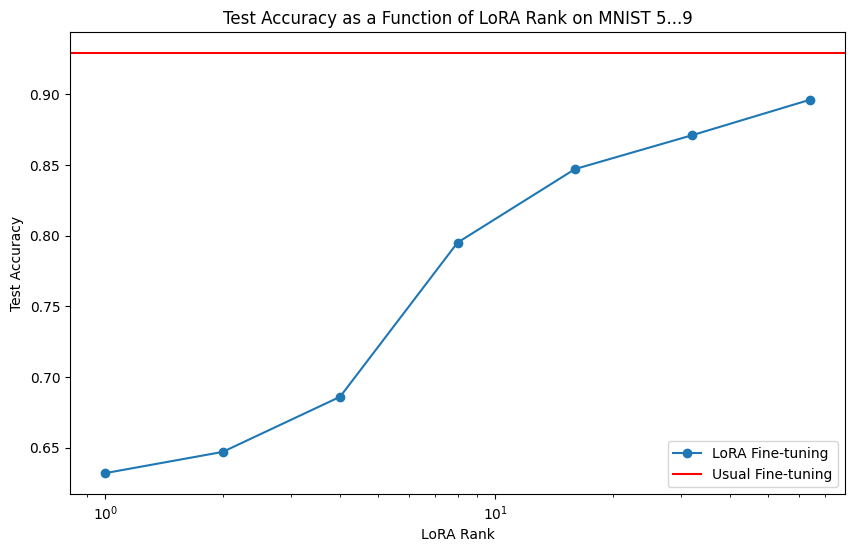

In [52]:
plt.figure(figsize=(10, 6))
plt.plot(lora_ranks, test_accuracies_lora, label='LoRA Fine-tuning', marker='o')
plt.axhline(y=test_accuracy_finetuned_subset2, color='r', linestyle='-', label='Usual Fine-tuning')
plt.xlabel('LoRA Rank')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy as a Function of LoRA Rank on MNIST 5...9')
plt.legend()
plt.xscale('log')
plt.show()

**[Observation]**  
As the LoRA rank increases, the test accuracy increases at the same time, along with an increase in the number of parameters added as well. But after certain rank, the increasing trend becomes flatter. We also observe that the LoRA approach can't really reach the same level of accuracy. However, it approaches this benchmark especially at higher ranks, suggesting that with fewer parameters, LoRA can come close to full model fine-tuning performance.

---
**[What are the pros of LoRA?]**  
- *Computational Efficiency* : It only updates a small fraction of the model's parameters so that it is able to save computational resources and thus enables the adaptation of very large models without retraining all again.

- *Flexibility* : Able to fine-tune models for new tasks without largely forgetting pre-trained model parameters.

- *Scalability* : As models become larger, fine-tuning and retraining entirely become impossible. LoRA's method scales better because the number of parameters added does not grow proportionally with the model size.

---
**[What possible applications do you envision for LoRA?]**  
- *Transfer Learning* : LoRA can be applied when adapting LLMs to specific domains or tasks, for example, legal document analysis or information extraction.

- *Edge Computing* : For applications where the model needs to be deployed on devices with limited computational resources, LoRA fine-tuning allows the deployment of powerful models in a resource-constrained environment.

- *Personalization* : In some cases, like product recommendation systems, the personalization is key. Therefore, LoRA can quickly adapt a general model to individual users' preferences without extensive retraining.